In [9]:
!pwd

/home/edolores/NEXTGEMS/tools/HW_contrack


In [147]:
from pyproj import Proj, Transformer, transform, CRS
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
#import xesmf as xe
import matplotlib.patches as mpatches
import glob
import os
import pandas as pd
import time
from itertools import groupby
from scipy.stats import linregress

In [148]:
### some functions
def compute_dtr(tx, tn):
    """
    Compute Daily Temperature Range (DTR) as the monthly mean of (TX - TN).

    Parameters:
        tx (xarray.DataArray): Daily maximum temperature (TX), with 'time' dimension.
        tn (xarray.DataArray): Daily minimum temperature (TN), same dimensions as tx.

    Returns:
        xarray.DataArray: Monthly mean daily temperature range.
    """
    # Ensure both inputs align in time and space
    tx, tn = xr.align(tx, tn)

    # Compute daily range
    dtr_daily = tx - tn

    # Compute monthly mean DTR
    dtr_monthly = dtr_daily.resample(time='ME').mean(dim='time', skipna=True)

    # Add metadata
    dtr_monthly.name = 'DTR'
    dtr_monthly.attrs.update({
        'long_name': 'Monthly mean daily temperature range',
        'units': tx.attrs.get('units', '°C'),
        'comment': 'Mean of daily (TX - TN), where TX is max and TN is min temperature.',
        'cell_methods': 'time: mean (of daily max - min)',
    })

    return dtr_monthly


def get_max_dry_spell(seq):
    """
    Get the length of the longest consecutive run of True (dry days) in a 1D boolean array.
    """
    return max((sum(1 for _ in group) for val, group in groupby(seq) if val), default=0)


def compute_CDD(precip, threshold=1.0):
    """
    Compute the maximum length of dry spells (CDD) using groupby logic.
    
    Parameters:
        precip (xarray.DataArray): Daily precipitation with time dim.
        threshold (float): Dry day threshold in mm (default: 1.0).
    
    Returns:
        xarray.DataArray: CDD values (max dry spell length) at each grid point.
    """
    # Get dry day mask
    dry_days = (precip < threshold)

#    dry_days=dry_days.astype(float)

    # Apply the get_max_dry_spell function along 'time' using xarray.apply_ufunc
    cdd = xr.apply_ufunc(
        get_max_dry_spell,
        dry_days,
        input_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[int]
    )

    cdd.name = 'CDD'
    cdd.attrs.update({
        'long_name': 'Maximum number of consecutive dry days',
        'units': 'days',
        'comment': 'CDD is the length of the longest dry spell (RR < 1 mm)',
    })

    return cdd,dry_days

# write our own function to get DataArrays with the results
def get_trend(xx: np.ndarray, yy: np.ndarray) -> (xr.DataArray, xr.DataArray, xr.DataArray):
    """Fit linear trend and p-value.

    Parameters
    ----------
    xx : np.ndarray, shape (N,)
    yy : np.ndarray, shape (N,)

    Returns
    -------
    tuple of DataArray : (slope, intercept, pvalue)
    """
    results = linregress(xx, yy, alternative='greater')  # only look for statistically significant positive trends
    return (
        xr.DataArray(results.slope, name='slope'),
        xr.DataArray(results.intercept, name='intercept'),
        xr.DataArray(results.pvalue, name='pvalue'),
    )

# Basic plots

In [149]:
### We load 2 m tempearture daily mean data for the Northern hemisphere 

In [152]:
da=xr.open_mfdataset('/scratch2/edolores/era5/TS_era5/t2m_day_19*_0p5deg.nc')['t2m']
da

<xarray.DataArray 't2m' (time: 2922, lat: 181, lon: 720)>
dask.array<concatenate, shape=(2922, 181, 720), dtype=float32, chunksize=(366, 181, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01T11:00:00 ... 1966-12-31T11:00:00
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 0.0 0.5 1.0 1.5 2.0 2.5 ... 88.0 88.5 89.0 89.5 90.0
Attributes:
    long_name:     2 metre temperature
    units:         K
    cell_methods:  time: mean
    institution:   ECMWF

In [153]:
### NH mean time series

In [155]:
era5_month=da.resample(time='1M').mean()
#era5_month.mean(dim=['lat', 'lon']).plot()

/home/edolores/.conda/envs/contrack_dev/lib/python3.8/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/edolores/.conda/envs/contrack_dev/lib/python3.8/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


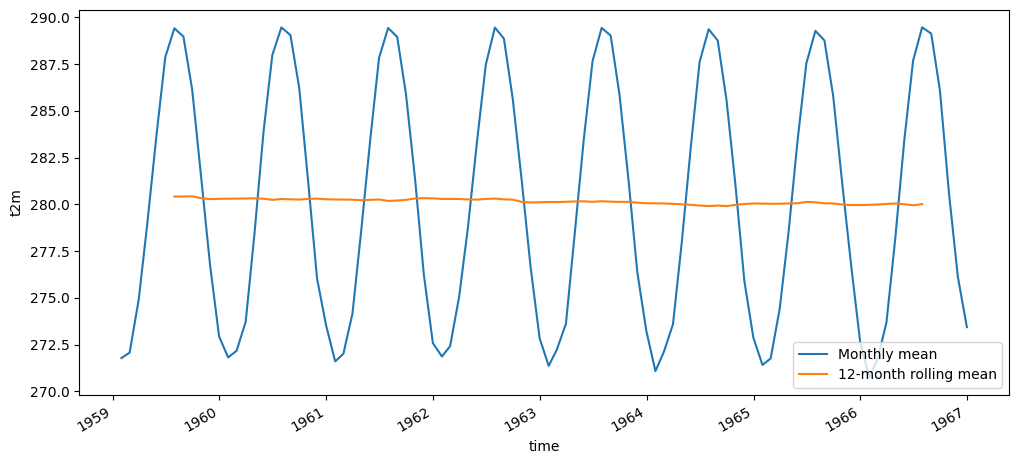

In [156]:
era5_month_mean = era5_month.mean(dim=["lat", "lon"])

# 12-month (1 year) rolling mean
#the window length (rolling(time=N)) depending on how much smoothing you want (e.g., 6 for half-year, 24 for 2 years).
era5_smooth = era5_month_mean.rolling(time=12, center=True).mean()

# Plot both raw monthly and smoothed
plt.figure(figsize=(12,5))
era5_month_mean.plot(label="Monthly mean")
era5_smooth.plot(label="12-month rolling mean")
plt.legend()
plt.show()

In [157]:
### NH map mean

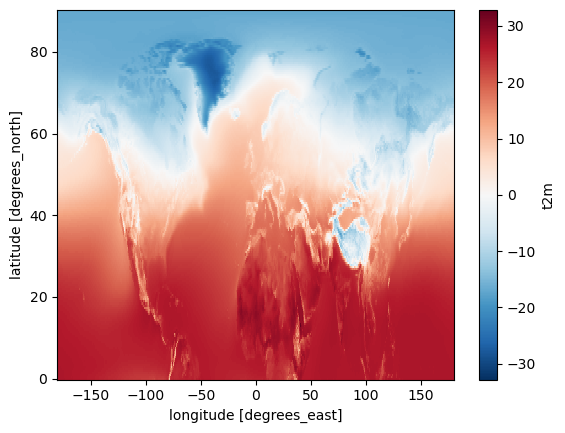

In [158]:
(era5_month-273.15).mean(dim=['time']).plot()

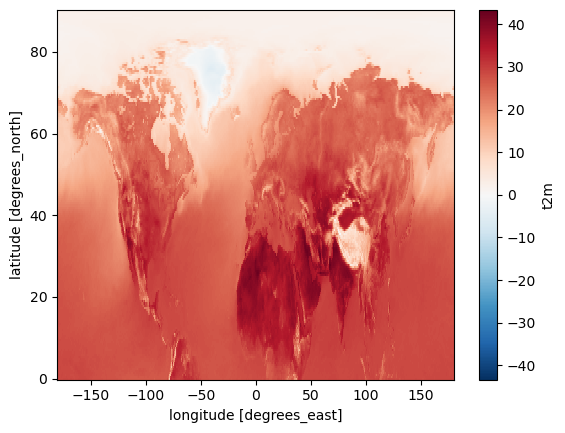

In [160]:
### max daily mean
(da-273.15).max(dim=['time']).plot()

In [161]:
### mean yearly
temp_year=era5_month.resample(time='1Y').mean()
temp_year
# Convert time to float years
time_in_years = temp_year['time'].dt.year + (temp_year['time'].dt.dayofyear - 1) / 365.25
print(time_in_years)

results = xr.apply_ufunc(
    get_trend,
    time_in_years, temp_year.compute(),
#    temp_year['time'], block_year,
    input_core_dims=[['time'], ['time']],
    output_core_dims=[[], [], []],
    vectorize=True,
)


ds = xr.Dataset(
    {'slope': results[0],
     'intercept': results[1],
     'pvalue': results[2],
    })
ds

<xarray.DataArray (time: 8)>
array([1959.99657769, 1960.99931554, 1961.99657769, 1962.99657769,
       1963.99657769, 1964.99931554, 1965.99657769, 1966.99657769])
Coordinates:
  * time     (time) datetime64[ns] 1959-12-31 1960-12-31 ... 1966-12-31


<xarray.Dataset>
Dimensions:    (lon: 720, lat: 181)
Coordinates:
  * lon        (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat        (lat) float32 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
Data variables:
    slope      (lat, lon) float64 -0.004015 -0.002451 ... -0.1483 -0.1483
    intercept  (lat, lon) float64 307.9 304.8 298.1 291.4 ... 547.5 547.5 547.5
    pvalue     (lat, lon) float64 0.5572 0.5346 0.4864 ... 0.9027 0.9027 0.9027

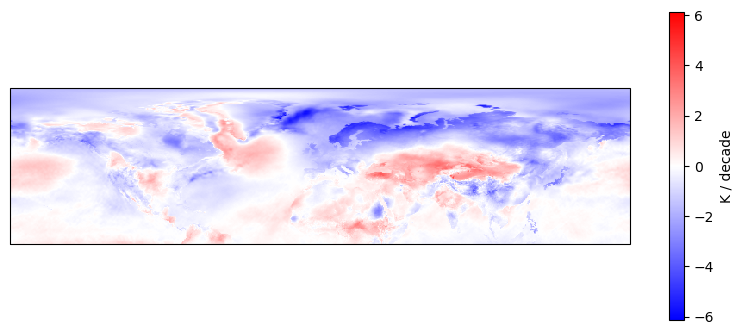

In [162]:
fig, ax = plt.subplots(figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()})
(ds['slope'] * 10).plot.pcolormesh(ax=ax, cmap='bwr', cbar_kwargs={'label': 'K / decade'})

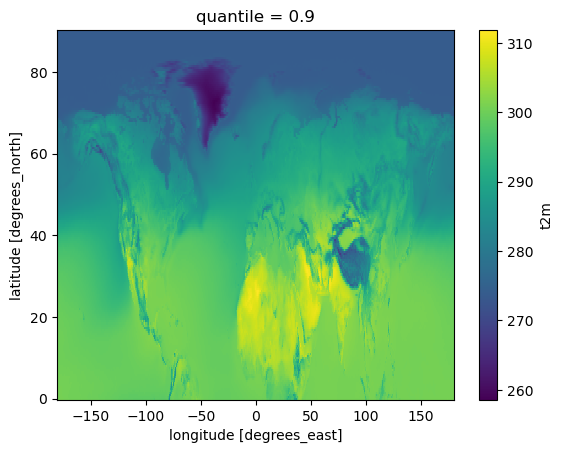

In [164]:
### percentiles
ds1 = da.chunk({"time": -1})
q90 = ds1.quantile(0.9, dim="time")
q90.plot()

In [166]:
### Mask to count days above the 20 (tropical nights) --> This should be minimum temperature
temp_mask = ((da-273.15) > 20).compute() # gives true and false values (which is our mask)
#temp_mask.compute()

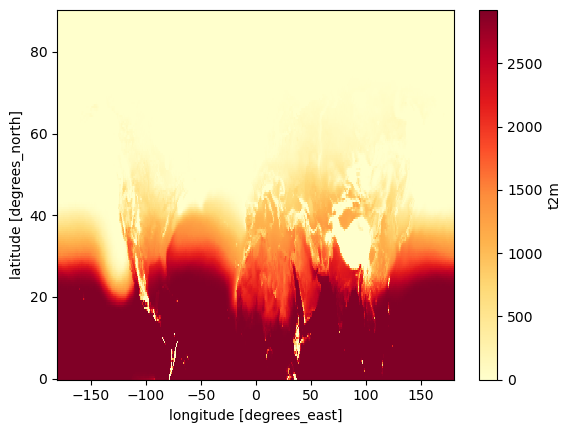

In [167]:
# Counting the days and plotting
temp_mask.sum(dim=["time"]).plot(
    cmap='YlOrRd'#, levels=np.arange(0, 200, 20)
)  # Sum up True values and plot the result

# Tracking heatwaves

In [168]:
### Preparing data to track heatwaves

In [169]:
#Get full dataset
temp = xr.open_mfdataset('/scratch2/edolores/era5/TS_era5/t2m_day_*_0p5deg.nc', chunks={"time": 365, "lon": -1, "lat": -1})['t2m']
temp

<xarray.DataArray 't2m' (time: 2922, lat: 181, lon: 720)>
dask.array<concatenate, shape=(2922, 181, 720), dtype=float32, chunksize=(365, 181, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01T11:00:00 ... 1966-12-31T11:00:00
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 0.0 0.5 1.0 1.5 2.0 2.5 ... 88.0 88.5 89.0 89.5 90.0
Attributes:
    long_name:     2 metre temperature
    units:         K
    cell_methods:  time: mean
    institution:   ECMWF

In [177]:
### selecting years
#dERA5 = pd.date_range(start="1959-01-01",end="2024-12-31")
dERA5 = pd.date_range(start="1959-01-01",end="1966-12-31")

### selecting months around summer (JJA)
dERA5 = dERA5[dERA5.month.isin([4, 5, 6, 7, 8, 9, 10])]

doyVec = pd.to_numeric(dERA5.strftime('%j'))

matExt = temp*0 ### replace name df

start = time.perf_counter()

In [189]:
print(len(dERA5) ,temp.time.size)
#dERA5

1712 2922


In [178]:
#tt=0
#(abs(doyVec-doyVec[tt])<=15)*(abs(dERA5-dERA5[tt])<='1475 days')

In [186]:
'''
print('calculating anomalies on moving 30-day 8-year moving window')

for tt in range(temp.time.size):
    print(tt)
    #30 day 8-year rolling window
    vec = (abs(doyVec-doyVec[tt])<=15)*(abs(dERA5-dERA5[tt])<='1475 days')
    matExt[tt,:,:] = (temp[tt,:,:] - temp[vec,:,:].mean('time'))/ temp[vec,:,:].std('time') ##standarized temperature
    
print('write anomalies to netcdf')
matExt = matExt.sel(time=matExt.time.dt.month.isin([5,6,7,8,9]))
matExt
'''

"\nprint('calculating anomalies on moving 30-day 8-year moving window')\n\nfor tt in range(temp.time.size):\n    print(tt)\n    #30 day 8-year rolling window\n    vec = (abs(doyVec-doyVec[tt])<=15)*(abs(dERA5-dERA5[tt])<='1475 days')\n    matExt[tt,:,:] = (temp[tt,:,:] - temp[vec,:,:].mean('time'))/ temp[vec,:,:].std('time') ##standarized temperature\n    \nprint('write anomalies to netcdf')\nmatExt = matExt.sel(time=matExt.time.dt.month.isin([5,6,7,8,9]))\nmatExt\n"

In [188]:
###
len(vec)

1712

In [184]:
### version two

In [190]:
# 1) Make sure temp is sliced to the same dates & months as you intend
temp = temp.sel(time=slice("1959-01-01", "1966-12-31"))
temp = temp.sel(time=temp["time.month"].isin([4,5,6,7,8,9,10]))

# 2) Prepare vectors from temp.time so lengths match
t = temp.time
doy = t.dt.dayofyear

# (optional) preallocate output with same shape
matExt = xr.zeros_like(temp)

print('calculating anomalies on moving 30-day 8-year moving window')

# helper for circular day-of-year difference (handles year wrap cleanly)
def circ_doy_diff(a, b):
    # a, b are numpy arrays or scalars of day-of-year (1..366)
    d = np.abs(a - b)
    return np.minimum(d, 365 - d)

for tt in range(t.size):
    # 30-day window (±15 days) using circular DOY difference
    w_doy = circ_doy_diff(doy.values, doy.values[tt]) <= 15

    # 8-year window centered on time[tt] → ±1475 days (~8.08 years total width)
    w_time = np.abs((t.values - t.values[tt]).astype('timedelta64[D]')) <= np.timedelta64(1475, 'D')

    # combine masks (both are boolean arrays with length == t.size)
    vec = w_doy & w_time

    # compute standardized anomalies
    clim = temp.isel(time=vec).mean('time')
    std  = temp.isel(time=vec).std('time')

    # avoid division by zero if any std == 0
    matExt[tt, :, :] = xr.where(std > 0, (temp.isel(time=tt) - clim) / std, np.nan)

calculating anomalies on moving 30-day 8-year moving window


In [ ]:
print('write anomalies to netcdf')
matExt = matExt.sel(time=matExt.time.dt.month.isin([5,6,7,8,9])).compute()
matExt

write anomalies to netcdf


In [ ]:
matExt.isel(time=0).plot()